# Regression

This notebook walks through regression, and presents the probabilistic formulation of classic regression methods that underpins generative modeling. We will implement everything from scratch in NumPy and JAX, and provide relevant derivations and references to further reading. Overall, we show that the probabilistic generative modeling approach brings two significant benefits:

- design prior knowledge into your model by specifying the data generation process
- perform principled model fitting and selection using the marginal likelihood

### Table of contents

1. [**Synthetic data**](#data)
2. [**Linear basis function models**](#linear)
    - [Linear regression with least squares](#linear_bayes)
    - [Nonlinear basis functions](#basis_map)
    - [Beyond one-dimensional inputs](#basis_1d)
3. [**Turning into generative models**](#basis)
    - [Probabilistic models with Bayesian inference](#linear_bayes)
    - [Bayesian linear regression](#linear_bayes)
    - [Bayesian basis function regression](#linear_bayes)
4. [**Gaussian process regression**](#gp)
    - [Kernel trick](#gp_trick)
    - [Choosing hyperparameters](#gp_trick)
5. [**Discussion**](#disc)
    - [Comparing model performances](#disc_comp)
    - [A note on non-Gaussian observations](#disc_note)

In [1]:
import numpy as np
import scipy as sc

import jax
import jax.numpy as jnp
import jax.scipy as jsc

from jax.example_libraries import optimizers

import matplotlib.pyplot as plt

# set JAX configs
jax.config.update('jax_platform_name', 'cpu')  # stay on CPU
jax.config.update('jax_enable_x64', True)  # use float64

<a id='data'></a>
## 1. Synthetic data

For real world data, noise $\epsilon_i$ is always present and 

$$ y_i = f(x_i) + \epsilon_i $$

for data points $i = 1, 2, \ldots, N$. This setup is common in neuroscience when relating neural activity $y$ to experimental stimuli or behaviour $x$, with the noise accounting for neural variability. To compare generative models of increasing expressivity, we will generate two datasets, one where there is a linear relation $f(x) = w \cdot x + b$ and another with a nonlinear relation 

$$
f(x) = 5 \cdot \sin( 3 x ) + x^2
$$

In [2]:
def func_linear(x):
    return 0.2 * x

def func_nonlinear(x):
    return 5. * np.sin(3 * x) + x**2

def compute_R2(f, y):  # compute coefficient of determination
    return 1 - ((y - f)**2).mean() / y.var()

In [3]:
# generate data
rng = np.random.default_rng(1234)  # seed everything

N = 50
N_test = 20

x_data = 6 * rng.uniform(size=(N,)) - 3
x_test = 6 * rng.uniform(size=(N_test,)) - 3

In [4]:
# linear data
std = 0.1
y_linear_cov = std**2 * jnp.eye(N)
eps = std * rng.normal(size=(N,))
y_linear = func_linear(x_data) + eps
eps = std * rng.normal(size=(N_test,))
y_linear_test = func_linear(x_test) + eps

# nonlinear data
std = 1.0
y_nonlinear_cov = std**2 * jnp.eye(N)
eps = std * rng.normal(size=(N,))
y_nonlinear = func_nonlinear(x_data) + eps
eps = std * rng.normal(size=(N_test,))
y_nonlinear_test = func_nonlinear(x_test) + eps

Here we visualize the training data:

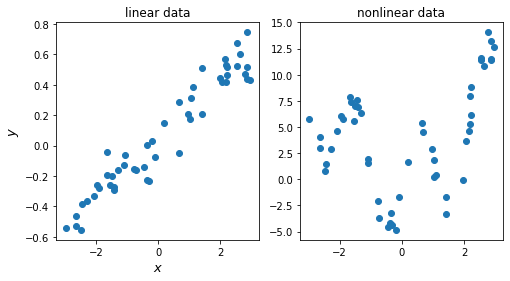

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
axes[1].scatter(x_data, y_nonlinear)

plt.show()

Here we visualize the test data, on which the models will be evaluated after fitting to training data:

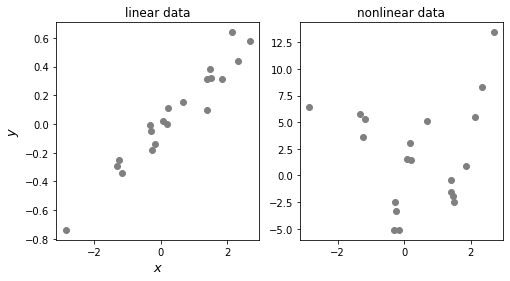

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].scatter(x_test, y_linear_test, c='gray')
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
axes[1].scatter(x_test, y_nonlinear_test, c='gray')

plt.show()

<a id='linear'></a>
## 2. Linear basis function models


<a id='linear_ls'></a>
### 2.1 Linear regression with least squares
To model dependencies between two variables, say $x$ and $y$, one of the simplest but most widely used methods is linear regression. As the name suggests, it attempts to capture their relation using a linear function 

$$ f(x) = w \cdot x + b $$



To select the parameters $w$ and $b$ that best describe the data, the common criterion is least squares. Here, we require such parameters to minimize the squared errors 

$$ L = \sum_i \| y_i - f(x_i) \|^2 $$


For linear regression, the least squares optimization problem $ \min_{w,b} L $ has a closed form solution 

$$ w = \frac{\frac{1}{N} \sum_i x_i y_i - \bar{x} \bar{y}}{\text{Var}(x)} $$

$$ b = \frac{\frac{1}{N} \sum_i x_i^2 y_i - \bar{x} \frac{1}{N} \sum_i x_i y_i}{\text{Var}(x)} $$

<details>
<summary><b>See derivation</b></summary>

$$ \min_{w,b} L = \min_{w,b} \sum_i \| y_i - w \cdot x_i - b \|^2 $$

$$ \partial_w L = 0 \Rightarrow \sum_i x_i \, ( y_i - w \cdot x_i - b  ) = 0 $$

$$ \partial_b L = 0 \Rightarrow \sum_i ( y_i - w \cdot x_i - b  ) = 0 $$

Now first rearranging for $b$ in the last equation and substituting into the second equation gives the solution for $w$, and plugging that into the last equation gives the solution for $b$.
    
</details>

In [7]:
def linear_regression(x, y):
    w = ((x * y).mean() - x.mean() * y.mean()) / x.var()
    b = ((x**2 * y).mean() - x.mean() * (x * y).mean()) / x.var()
    return w, b

Conventionally, we can assess the model fit with the coefficient of determination 

$$ R^2 = 1 - \frac{\sum_i (y_i - f_i)^2}{\sum_i (y_i - \bar{y})^2} $$

In [8]:
w_lin, b_lin = linear_regression(x_data, y_linear)
w_non, b_non = linear_regression(x_data, y_nonlinear)

# compute test performance
f_linear_test = w_lin * x_test + b_lin
f_nonlinear_test = w_non * x_test + b_non

R2_linear = compute_R2(f_linear_test, y_linear_test)
R2_nonlinear = compute_R2(f_nonlinear_test, y_nonlinear_test)

linear_regression_dict = {
    "R2_linear": R2_linear, 
    "R2_nonlinear": R2_nonlinear, 
}

# plot
x_plot = np.linspace(-4., 4., 300)
f_linear = w_lin * x_plot + b_lin
f_nonlinear = w_non * x_plot + b_non

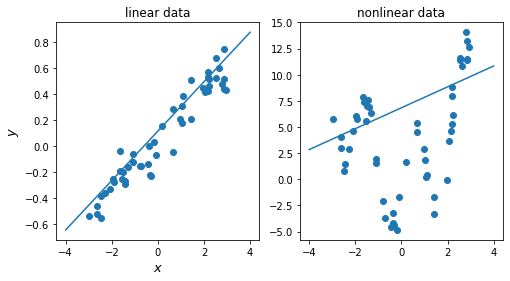

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].plot(x_plot, f_linear)
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
axes[1].plot(x_plot, f_nonlinear)
axes[1].scatter(x_data, y_nonlinear)

plt.show()

For didactic purposes, we derived linear regression from scratch. As linear regression is a widely used tool, standard implementations are readily available in libraries like [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

For notational convenience, we can group the parameters into a vector $\mathbf{w} = [w, b]$ and define a basis set $\boldsymbol{\phi}(x) = [1, x]$ which maps $x$ to another vector. As we map a scalar to a two-dimensional vector, this is an example of a basis expansion. We can succinctly write 

$$
f(x) = \mathbf{w} \cdot \boldsymbol{\phi}(x)
$$

<a id='linear_basis'></a>
### 2.2 Nonlinear basis functions
So far, our statistical models only account for linear relations between $x$ and $y$. To go beyond linear, we can introduce nonlinear basis functions to expand the input space. For example, we can introduce a cubic polynomial 

$$ \boldsymbol{\phi}(x) = [1, x, x^2, x^3] $$

where now we have four weights instead of two in the linear regression case above. We can write the basis expansion for multiple data point $(y_1, x_1), (y_2, x_2), \ldots (y_N, x_N)$ as a matrix 

$$ \Phi_{ki} = \phi_k(x_i)$$

One can derive the least squares solution for general basis expansions in a similar manner to the special case for linear regression above 

$$ \mathbf{w} = (\Phi \Phi^T)^{-1} \Phi \mathbf{y} $$

where $\mathbf{y} = [y_1, y_2, \ldots, y_N]$.

<details>
<summary><b>See derivation</b></summary>

From the least squares criterion 
    
$$ \text{min}_{\mathbf{w}} L = \text{min}_{\mathbf{w}} \sum_i \| y_i - \mathbf{w}^T \boldsymbol{\phi}(x_i) \|^2 $$
    
We can write 
    
$$ \| y_i - \mathbf{w}^T \boldsymbol{\phi}(x_i) \|^2 = y_i^2 + \left( \mathbf{w}^T \boldsymbol{\phi}(x_i) \right)^2 - 2 \mathbf{w}^T \boldsymbol{\phi}(x_i) y_i $$
    
and from minimization 
    
$$ \nabla_{\mathbf{w}} L = \sum_i 2 \left( \mathbf{w}^T \boldsymbol{\phi}(x_i) \right) \boldsymbol{\phi}(x_i) - 2 y_i \boldsymbol{\phi}(x_i) = 0 $$
    
we obtain the solution noting that 
    
$$ \Phi \Phi^T = \sum_i \boldsymbol{\phi}(x_i) \, \boldsymbol{\phi}^T(x_i) $$
    
</details>


In [10]:
def phi_linear(x):  # basis set for linear functions
    return jnp.stack([x**0, x**1], axis=1)  # (N, dims)


def phi_cubic(x):  # basis set for cubic functions
    return jnp.stack([x**0, x**1, x**2, x**3], axis=1)  # (N, dims)
# NOTE: numerically more stable to rescale each basis so numerical values in [-1, 1] range

In [11]:
feature_mat = phi_cubic(x_data)
pseudo_inv = jnp.linalg.pinv(feature_mat)

# test performance
feature_test = phi_cubic(x_test)

w_linear = pseudo_inv @ y_linear[:, None]
f_linear = (feature_test @ w_linear)[:, 0]

w_nonlinear = pseudo_inv @ y_nonlinear[:, None]
f_nonlinear = (feature_test @ w_nonlinear)[:, 0]

R2_linear = compute_R2(f_linear, y_linear_test)
R2_nonlinear = compute_R2(f_nonlinear, y_nonlinear_test)

basis_regression_dict = {
    "R2_linear": R2_linear, 
    "R2_nonlinear": R2_nonlinear, 
}


# plotting
feature_plot = phi_cubic(x_plot)

w_linear = pseudo_inv @ y_linear[:, None]
f_linear = feature_plot @ w_linear

w_nonlinear = pseudo_inv @ y_nonlinear[:, None]
f_nonlinear = feature_plot @ w_nonlinear

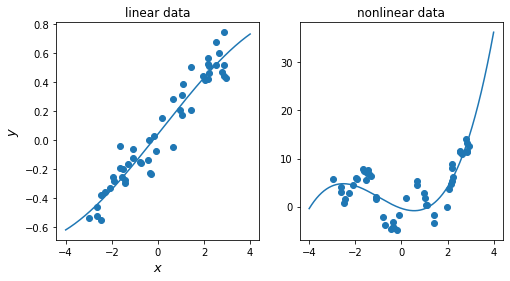

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].plot(x_plot, f_linear)
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
axes[1].plot(x_plot, f_nonlinear)
axes[1].scatter(x_data, y_nonlinear)

plt.show()


<a id='linear_1d'></a>
### 2.3 Beyond one-dimensional inputs

The above assumes only one input dimension. Often, one wants to find relations between some observations and multi-dimensional inputs, e.g. 2D animal position $\mathbf{x} = (x_1, x_2)$. A straightforward extension is to concatenate the expansion of the dimensions, i.e. 

$$
\phi(\mathbf{x}) = (1, x_1, x_1^2, x_2, x_2^2 , \ldots)
$$

but this will only yield functions that decompose across input dimensions $f(x_1, x_2) = f_1(x_1) + f_2(x_2)$. To obtain more general functions $f(x_1, x_2)$, we need to introduce interactions like $x_1 \cdot x_2$ in our basis expansion set 

$$
\phi(\mathbf{x}) = (1, x_1, x_1^2, x_2, x_2^2 , x_1 x_2 )
$$

with this particular basis set leading to quadratic functions of the input, which can for instance be used to model [Gaussian place cell tuning curves](https://www.jneurosci.org/content/18/18/7411).

In [13]:
def phi_2D_quad(x):
    x_1, x_2 = x[:, 0], x[:, 1]
    return jnp.stack([x_1**0, x_1**1, x_1**2, x_2**1, x_2**2, x_1 * x_2], axis=1)  # (N, dims)


We can visualize the 2D function surfaces for some randomly chosen weights:

In [14]:
N_samps = 4

# sample functions
x_2D = np.meshgrid(np.linspace(-3., 3., 40), np.linspace(-3., 3., 40))
x_2D = np.stack(x_2D, axis=-1).reshape(-1, 2)

feature_plot = phi_2D_quad(x_2D)

w = rng.normal(size=(feature_plot.shape[-1], N_samps))
f_samps = feature_plot @ w  # (evals, samps)
f_samps = f_samps.reshape(40, 40, N_samps)

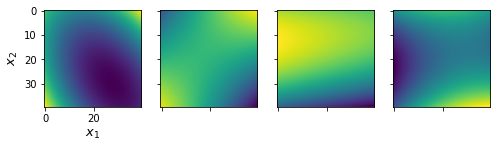

In [15]:
fig, axes = plt.subplots(1, N_samps, figsize=(8, 4))

axes[0].set_xlabel(r'$x_1$', fontsize=13)
axes[0].set_ylabel(r'$x_2$', fontsize=13)

for k in range(N_samps):
    axes[k].imshow(f_samps[..., k])
    if k > 0:
        axes[k].set_xticklabels([])
        axes[k].set_yticklabels([])
    
plt.show()

<a id='bayes'></a>
## 3. Turning into generative models

<a id='linear_bayes'></a>
### 3.1 Probabilistic models with Bayesian inference


#### Model weights as random variables

Instead of the least squares criterion, one can start thinking in terms of how the data was generated. In a generative modeling approach, we have to be explicit and state our assumptions about the data generation process. We treat the parameters as random variables drawn from 

$$ \mathbf{w} \sim \mathcal{N}(\mathbf{0}, I) $$

and each time we want to create a data point, we draw a random vector parameters from this distribution. Furthermore, we choose the observation noise $\epsilon$ to be i.i.d. Gaussian noise 

$$ \epsilon \sim \mathcal{N}(0, \sigma_{\text{obs}}^2) $$

which gives the overall data generation process per data point 

$$ y = \mathbf{w} \cdot \boldsymbol{\phi}(x) + \epsilon $$

with the random variables $(\mathbf{w}, \epsilon)$ drawn from their respective distributions.

Treating the unknown model parameters as random variables now defines a distribution over all possible models $p\left( f(x) \right)$, and we can visualize samples drawn from this distribution. Each sample is a different possible "explanation" of the data that our generative model can yield.


In [16]:
N_samps = 10
x_plot = np.linspace(-4., 4., 100)

w, b = rng.normal(size=(N_samps,)), rng.normal(size=(N_samps,))
f_samps_lin = (w[:, None] * x_plot + b[:, None]).T  # (evals, samps)

feature_plot = phi_cubic(x_plot)
w = rng.normal(size=(feature_plot.shape[-1], N_samps))
f_samps_nonlin = feature_plot @ w  # (evals, samps)

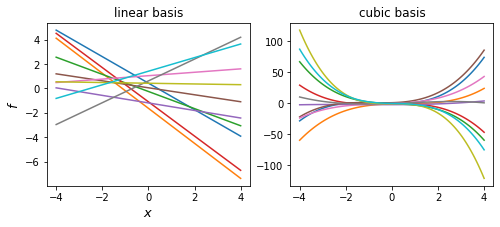

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ax = axes[0]
ax.plot(x_plot, f_samps_lin)
ax.set_xlabel(r'$x$', fontsize=13)
ax.set_ylabel(r'$f$', fontsize=13)
ax.set_title('linear basis')

ax = axes[1]
ax.plot(x_plot, f_samps_nonlin)
ax.set_title('cubic basis')

plt.show()

We thus see that our generative model defines a distribution of what we expect the data to look like, before actually observing any data! This is referred to as the *prior distribution* in Bayesian inference. Observing data $y$ allows us to apply Bayes' rule 

$$ p(\mathbf{w}|\mathbf{y}) =  \frac{p(\mathbf{y}|\mathbf{w}) \, p(\mathbf{w})}{p(\mathbf{y})} $$

Unlike with least squares, we have an entire distribution over the parameters expressing our uncertainty in estimating each parameter. This is called the *posterior distribution*.


<details>
<summary><b>See explicit formula</b></summary>

$$ p(\mathbf{w}|\mathbf{y}) = \frac{p(\mathbf{y} | \mathbf{w}) \, p(\mathbf{w})}{p(\mathbf{y})} \propto p(\mathbf{y} | \mathbf{w}) \, p(\mathbf{w})$$
    
$$ \log{ p(\mathbf{y} | \mathbf{w}) \, p(\mathbf{w}) } = -\frac{1}{2} \sum_i \left( y_i - \mathbf{w}^T \, \boldsymbol{\phi}(x_i) \right) \sigma_{\text{obs}}^{-2} \left( y_i - \mathbf{w}^T \, \boldsymbol{\phi}(x_i) \right) - \frac{1}{2} \mathbf{w}^T \, \mathbf{w} + \ldots$$
    
where we ignore all terms independent of $\mathbf{w}$ (which contribute to the normalization of the posterior density). We note that this is a quadratic in $\mathbf{w}$, hence we can complete the square and obtain 
    
$$ \log{ p(\mathbf{w}|\mathbf{y}) } = -\frac{1}{2} (\mathbf{w} - \boldsymbol{\mu})^T M (\mathbf{w} - \boldsymbol{\mu}) + \ldots $$
    
which implies $p(\mathbf{w}|\mathbf{y})$ is a multivariate Gaussian with the precision matrix and mean vector 
    
$$ M = \sigma_{\text{obs}}^{-2} \left( \Phi \Phi^T + \sigma_{\text{obs}}^2 I \right), \boldsymbol{\mu} = M^{-1} \Phi \mathbf{y} $$
    
</details>

In [18]:
def weights_posterior(x, y_obs, obs_var, phi_func):
    phi = phi_func(x)  # (eval_pts, dims)
    num_params = phi.shape[-1]
    
    M = (phi.T @ phi + obs_var * jnp.eye(num_params))
    L_prec = jnp.linalg.cholesky(M)
    
    v = jsc.linalg.solve_triangular(L_prec, phi.T @ y_obs[:, None], lower=True)
    mu = jsc.linalg.solve_triangular(L_prec, v, lower=True)
    
    return mu, L_prec


def heatmap_2D_gaussian(xlims, ylims, mu, L_prec, G=100):
    x_2D = np.meshgrid(
        np.linspace(xlims[0], xlims[1], G), np.linspace(ylims[0], ylims[1], G))
    x_2D = np.stack(x_2D, axis=-1).reshape(-1, 2)

    v = x_2D[..., None] - mu[None, ...]  # (eval_pts, dims, 1)
    u = (L_prec.T @ v)[..., 0]
    log_likelihood = -.5 * (u**2).sum(-1) - .5 * jnp.log( 2 * np.pi ) + jnp.log(jnp.diag(L_prec)).sum()

    return jnp.exp(log_likelihood).reshape(G, G)

#### Relation to least squares

Least squares can be seen as equivalent to maximum likelihood in the probabilistic perspective with Gaussian observation noise, where we obtain point estimates of the parameters $\mathbf{w}$ directly from the likelihood 

$$ \mathbf{w} = \text{argmax}_{\mathbf{w}} p(y|\mathbf{w})$$

If we incorporate the prior $p(\mathbf{w})$ in the point estimation framework, we can do the same thing with the posterior distributions $p(\mathbf{w}|y)$, referred to as maximum a posteriori (MAP) estimation 

$$ \mathbf{w} = \text{argmax}_{\mathbf{w}} p(\mathbf{w}|y) = \text{argmax}_{\mathbf{w}} p(y|\mathbf{w}) \, p(\mathbf{w})$$

Note the prior becomes a regularizer, in this case a Gaussian prior is equivalent to [$L^2$ regularization](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization).

#### Function space inference

In the plots above, we actually see function samples from the distribution over functions $p(f(\cdot))$, which provides a perspective directly in the function space without the model weights. However, $f(\cdot)$ is not a finite vector like $\mathbf{w}$, but we can equivalently write the corresponding posterior distribution over function values $\mathbf{f}$ evaluated at locations $\mathbf{x}$, i.e. $\mathbf{f} = [f(x_1), \ldots, f(x_N)]$, to work with finite vectors 

$$ p(\mathbf{f}) = \mathcal{N}(0, K)$$

with the Gramian matrix $K = \Phi^T \Phi$. This follows form the relation $\mathbf{f} = \Phi^T \mathbf{w}$ with $\mathbf{w} \sim \mathcal{N}(0, I)$. In the machine learning literature, the weight perspective is also referred to as the primal form, whereas the functional perspective using Gramian matrices is known as the [dual form](https://homepages.rpi.edu/~bennek/class/mds/lecture/lecture6-06.pdf).

Similar to above, we can compute the posterior $p(\mathbf{f}|\mathbf{y})$ with Bayes' rule. However, to evaluate our inferred function outside the observed locations $\mathbf{x}$, we need to compute a slightly more general quantity $p(\mathbf{f}_*|\mathbf{y})$ called the predictive posterior, with $\mathbf{f}_*$ the function values at arbitrary evaluation locations $\mathbf{x}_*$.

<details>
<summary><b>See explicit formula</b></summary>
    
We first consider the joint distribution which follows from the linear basis function model 
    
$$ p(\mathbf{f}, \mathbf{f}_*) = \mathcal{N}\left( \begin{bmatrix}\mathbf{0} \\ \mathbf{0}\end{bmatrix}, \begin{bmatrix}K_{xx} & K_{x*} \\ K_{*x} & K_{**}\end{bmatrix} \right) $$
    
with $\left(K_{x*}\right)_{ij} = \boldsymbol{\phi}(x_i) \, \boldsymbol{\phi}^T(x_{*j})$ and so on. We can consider the joint with the Gaussian likelihood 
    
$$ p(\mathbf{y}, \mathbf{f}_*) = \int p(\mathbf{y} | \mathbf{f}) \, p(\mathbf{f}, \mathbf{f}_*) \, \mathrm{d}\mathbf{f} = \mathcal{N}\left( \begin{bmatrix}\mathbf{0} \\ \mathbf{0}\end{bmatrix}, \begin{bmatrix}K_{xx} + \sigma_{\text{obs}}^2 I & K_{x*} \\ K_{*x} & K_{**}\end{bmatrix} \right) $$

Then using a standard results for [conditional distributions of multivariate Gaussians](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions) we obtain 

$$ p(\mathbf{f}_*|\mathbf{y}) = \mathcal{N}(K_{*x} C^{-1} \mathbf{y}, K_{**} - K_{*x} C^{-1} K_{x*}) $$
    
with $C = K_{xx} + \sigma_{\text{obs}}^2 I$.

It is interesting to briefly reflect on the computational differences between the weight space and function space solutions. Just as a reminder, the model predictions are 

$$ f(x_*) = \mathbf{\phi}^T(x_*) \, \mathbf{w}  = \mathbf{\phi}^T(x_*) \, (\Phi \sigma_{\text{obs}}^{-2} \Phi^T + I_L)^{-1} \Phi \mathbf{y} \quad \text{(weight space)}$$

$$ f(x_*) = \mathbf{\phi}^T(x_*) \, \Phi^T (\Phi^T \Phi + \sigma_{\text{obs}}^{2} I_N)^{-1} \mathbf{y} \quad \text{(function space)}$$

For $N$ data points and a basis expansion into $L$ elements, the Gramian $\Phi$ has dimensions $L \times N$. We have the bottleneck in weight space being the inversion of a matrix of size $L$ giving $O(L^3)$, whereas in function space this is a size $N$ matrix inversion giving $O(N^3)$.

    
</details>


In [19]:
def MVN_posterior(Kxs, Kxx, Kss, y_obs, y_cov):
    N = Kxx.shape[-1]
    
    Le = jnp.linalg.cholesky(Kxx + y_cov)
    Ley = jsc.linalg.solve_triangular(Le, y_obs[:, None], lower=True)
    LeK = jsc.linalg.solve_triangular(Le, Kxs, lower=True)
    
    pred_mean = LeK.T @ Ley
    pred_cov = Kss - LeK.T @ LeK
    
    return pred_mean[:, 0], pred_cov


def sample_MVN(rng, mu, cov, jitter=1e-8):
    D = cov.shape[-1]
    L = np.linalg.cholesky(cov + jitter * jnp.eye(D))
    return mu + L @ rng.normal(size=mu.shape)


def Gramian(x, y, phi_func):
    Phi_x = phi_func(x)  # (eval_pts, dims)
    Phi_y = phi_func(y)
    Kxy = Phi_x @ Phi_y.T
    return Kxy

#### Goodness-of-fit and the marginal likelihood

The coefficient of determination is agnostic to the model or method used, only using the predictions $f_i$. The probabilistic approach naturally assigns a number to how well the data $y$ is described under the generative model, called the marginal likelihood 

$$ p(\mathbf{y}) = \int p(\mathbf{y}|\mathbf{w}) \, p(\mathbf{w}) \, \mathrm{d}\mathbf{w} = \int p(\mathbf{y}|\mathbf{f}) \, p(\mathbf{f}) \, \mathrm{d}\mathbf{f} $$

where we first wrote the integral explicitly in terms of parameters and then the equivalent integral in function space. Note this is essentially a weighted likelihood under the prior. One can interpret this as averaging or "integrating" out all possible model explanations given by our generative model.


<details>
<summary><b>See explicit formula</b></summary>

Note this is exactly the normalization term we ignored in the derivations above. We now work in the dual form:
    
$$ p(\mathbf{y}) = \int p(\mathbf{y} | \mathbf{f}) \, p(\mathbf{f}) \, \mathrm{d}\mathbf{f} $$
    
This kind of Gaussian integral will result in another Gaussian, as the product in the integral is the exponential of a quadratic form in $\mathbf{y}$ and $\mathbf{f}$. In particular, we can interpret it as adding observation noise to our prior, giving 
    
$$ p(\mathbf{y}) = \mathcal{N}(\mathbf{0}, K + \sigma_{\text{obs}}^2 I) $$
    
</details>

In [20]:
def MVN_log_marginal(Kxx, y_obs, y_cov):
    d_x = y_obs.shape[0]
    
    Le = jnp.linalg.cholesky(Kxx + y_cov)
    Ley = jsc.linalg.solve_triangular(Le, y_obs[:, None], lower=True)
    
    lml = -.5 * (Ley.T @ Ley).sum() - .5 * d_x * jnp.log(2 * jnp.pi) - jnp.log(jnp.diag(Le)).sum()
    return lml

<a id='linear_bayes'></a>
### 3.2 Bayesian linear regression

For the rest of the examples in this notebook, we fix the observation noise to the ground truth value, meaning we have the ground truth likelihood 

$$ p(y|f) = \mathcal{N}(y|f, \sigma_{\text{obs}}^2) $$

In practice, we do not know the ground truth data generation process and one generally needs to infer $\sigma_{\text{obs}}$ or generally parameters of the chosen likelihood function.

With no observed data, we can visualize the prior in the function space $p(f(x))$ by plotting the mean and standard deviations at each point $x$ of $p(f(x))$, or in the parameter space $p(\mathbf{w}) = p(w,b)$.

In [21]:
Kss = Gramian(x_plot, x_plot, phi_linear)
post_std = np.sqrt(jnp.diag(Kss))
post_samples = sample_MVN(rng, jnp.zeros((N_samps, Kss.shape[-1], 1)), Kss)

L = 10.
hm = np.array(heatmap_2D_gaussian([-L, L], [-L, L], jnp.zeros(2)[:, None], jnp.eye(2)))

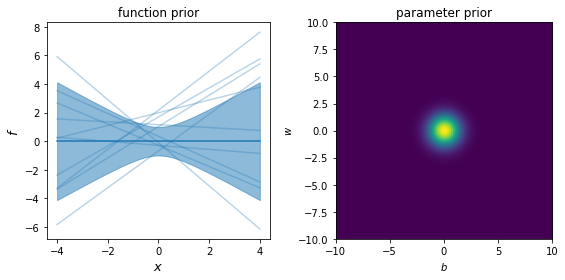

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('function prior')
line, = axes[0].plot(x_plot, np.zeros_like(x_plot))
axes[0].plot(x_plot, post_samples[..., 0].T, color=line.get_color(), alpha=0.3)
axes[0].fill_between(
    x_plot, -post_std, post_std, 
    color=line.get_color(), alpha=0.5
)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$f$', fontsize=13)

axes[1].set_title('parameter prior')
axes[1].imshow(hm, origin='lower', extent=[-L, L, -L, L])
axes[1].set_ylabel(r'$w$')
axes[1].set_xlabel(r'$b$')

plt.tight_layout()
plt.show()

Applying the expressions for the function and weight posterior to the linear regression model, we can now plot the posterior under a single observation point: 

In [23]:
Nobs = 1

Kxx = Gramian(x_data[:Nobs], x_data[:Nobs], phi_linear)
Kxs = Gramian(x_data[:Nobs], x_plot, phi_linear)
Kss = Gramian(x_plot, x_plot, phi_linear)

post_mean_linear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_linear[:Nobs], y_linear_cov[:Nobs, :Nobs])
post_std_linear = np.sqrt(jnp.diag(post_cov))
post_samples_linear = sample_MVN(
    rng, post_mean_linear[None, :, None].repeat(N_samps, axis=0), post_cov)


Kxx = Gramian(x_data[:Nobs], x_data[:Nobs], phi_linear)
Kxs = Gramian(x_data[:Nobs], x_plot, phi_linear)
Kss = Gramian(x_plot, x_plot, phi_linear)

post_mean_nonlinear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear[:Nobs], y_nonlinear_cov[:Nobs, :Nobs])
post_std_nonlinear = np.sqrt(jnp.diag(post_cov))
post_samples_nonlinear = sample_MVN(
    rng, post_mean_nonlinear[None, :, None].repeat(N_samps, axis=0), post_cov)


mu, L_prec = weights_posterior(x_data[:Nobs], y_linear[:Nobs], y_linear_cov[0, 0], phi_linear)
hm_linear = np.array(heatmap_2D_gaussian([-L, L], [-L, L], mu, L_prec))

mu, L_prec = weights_posterior(x_data[:Nobs], y_nonlinear[:Nobs], y_nonlinear_cov[0, 0], phi_linear)
hm_nonlinear = np.array(heatmap_2D_gaussian([-L, L], [-L, L], mu, L_prec))

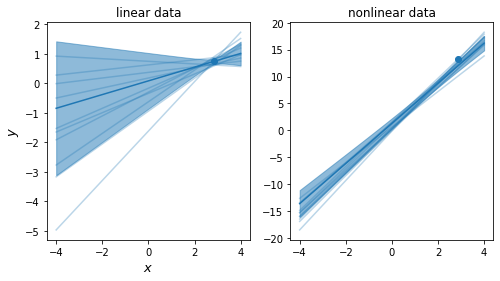

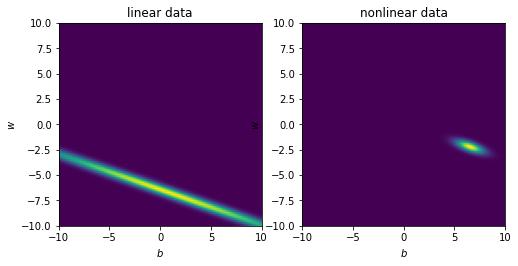

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].plot(x_plot, post_samples_linear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data[:Nobs], y_linear[:Nobs])
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].plot(x_plot, post_samples_nonlinear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data[:Nobs], y_nonlinear[:Nobs])


fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].imshow(hm_linear, origin='lower', extent=[-L, L, -L, L])
axes[0].set_ylabel(r'$w$')
axes[0].set_xlabel(r'$b$')

axes[1].set_title('nonlinear data')
axes[1].imshow(hm_nonlinear, origin='lower', extent=[-L, L, -L, L])
axes[1].set_ylabel(r'$w$')
axes[1].set_xlabel(r'$b$')

plt.show()

As we observe more data, our posterior becomes more certain. This is intuitive as we obtain more and more information.

In [25]:
Nobs = 10

Kxx = Gramian(x_data[:Nobs], x_data[:Nobs], phi_linear)
Kxs = Gramian(x_data[:Nobs], x_plot, phi_linear)
Kss = Gramian(x_plot, x_plot, phi_linear)

post_mean_linear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_linear[:Nobs], y_linear_cov[:Nobs, :Nobs])
post_std_linear = np.sqrt(jnp.diag(post_cov))
post_samples_linear = sample_MVN(
    rng, post_mean_linear[None, :, None].repeat(N_samps, axis=0), post_cov)


Kxx = Gramian(x_data[:Nobs], x_data[:Nobs], phi_linear)
Kxs = Gramian(x_data[:Nobs], x_plot, phi_linear)
Kss = Gramian(x_plot, x_plot, phi_linear)

post_mean_nonlinear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear[:Nobs], y_nonlinear_cov[:Nobs, :Nobs])
post_std_nonlinear = np.sqrt(jnp.diag(post_cov))
post_samples_nonlinear = sample_MVN(
    rng, post_mean_nonlinear[None, :, None].repeat(N_samps, axis=0), post_cov)


mu, L_prec = weights_posterior(x_data[:Nobs], y_linear[:Nobs], y_linear_cov[0, 0], phi_linear)
hm_linear = np.array(heatmap_2D_gaussian([-L, L], [-L, L], mu, L_prec))

mu, L_prec = weights_posterior(x_data[:Nobs], y_nonlinear[:Nobs], y_nonlinear_cov[0, 0], phi_linear)
hm_nonlinear = np.array(heatmap_2D_gaussian([-L, L], [-L, L], mu, L_prec))

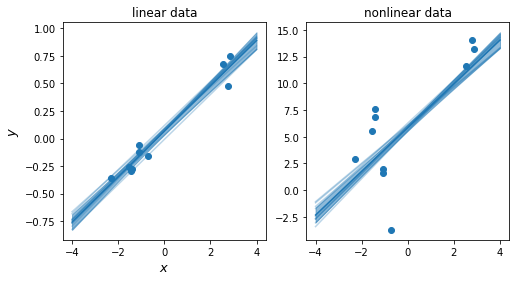

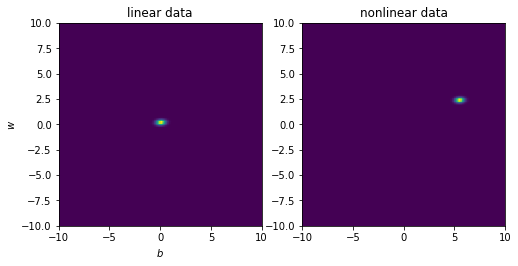

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].plot(x_plot, post_samples_linear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data[:Nobs], y_linear[:Nobs])
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].plot(x_plot, post_samples_nonlinear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data[:Nobs], y_nonlinear[:Nobs])


fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].imshow(hm_linear, origin='lower', extent=[-L, L, -L, L])
axes[0].set_ylabel(r'$w$')
axes[0].set_xlabel(r'$b$')

axes[1].set_title('nonlinear data')
axes[1].imshow(hm_nonlinear, origin='lower', extent=[-L, L, -L, L])

plt.show()

On the entire training dataset: 

In [27]:
Kxx = Gramian(x_data, x_data, phi_linear)
Kxs = Gramian(x_data, x_plot, phi_linear)
Kss = Gramian(x_plot, x_plot, phi_linear)

post_mean_linear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)
post_std_linear = np.sqrt(jnp.diag(post_cov))
post_samples_linear = sample_MVN(
    rng, post_mean_linear[None, :, None].repeat(N_samps, axis=0), post_cov)


Kxx = Gramian(x_data, x_data, phi_linear)
Kxs = Gramian(x_data, x_plot, phi_linear)
Kss = Gramian(x_plot, x_plot, phi_linear)

post_mean_nonlinear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)
post_std_nonlinear = np.sqrt(jnp.diag(post_cov))
post_samples_nonlinear = sample_MVN(
    rng, post_mean_nonlinear[None, :, None].repeat(N_samps, axis=0), post_cov)


mu, L_prec = weights_posterior(x_data, y_linear, y_linear_cov[0, 0], phi_linear)
hm_linear = np.array(heatmap_2D_gaussian([-L, L], [-L, L], mu, L_prec))

mu, L_prec = weights_posterior(x_data, y_nonlinear, y_nonlinear_cov[0, 0], phi_linear)
hm_nonlinear = np.array(heatmap_2D_gaussian([-L, L], [-L, L], mu, L_prec))

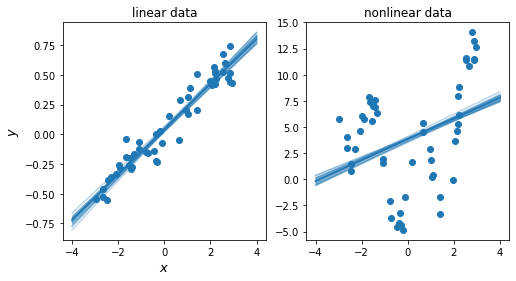

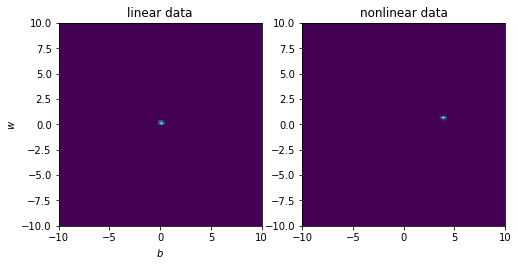

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].plot(x_plot, post_samples_linear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].plot(x_plot, post_samples_nonlinear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data, y_nonlinear)


fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].imshow(hm_linear, origin='lower', extent=[-L, L, -L, L])
axes[0].set_ylabel(r'$w$')
axes[0].set_xlabel(r'$b$')

axes[1].set_title('nonlinear data')
axes[1].imshow(hm_nonlinear, origin='lower', extent=[-L, L, -L, L])

plt.show()

In [29]:
Kxs = Gramian(x_data, x_test, phi_linear)
Kss = Gramian(x_test, x_test, phi_linear)
post_mean_linear, _ = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)
post_mean_nonlinear, _ = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)

R2_linear = compute_R2(post_mean_linear, y_linear_test)
R2_nonlinear = compute_R2(post_mean_nonlinear, y_nonlinear_test)

LML_linear = MVN_log_marginal(Kxx, y_linear, y_linear_cov)
LML_nonlinear = MVN_log_marginal(Kxx, y_nonlinear, y_nonlinear_cov)

blinear_regression_dict = {
    "R2_linear": R2_linear, 
    "R2_nonlinear": R2_nonlinear, 
    "LML_linear": LML_linear, 
    "LML_nonlinear": LML_nonlinear, 
}

<a id='bayes_prob'></a>
### 3.3 Bayesian basis function regression

Similar to Bayesian linear regression, we now apply the expressions to the cubic expansion. The weight posterior is now four-dimensional, and thus we no longer visualize it.

In [30]:
Nobs = 1

Kxx = Gramian(x_data[:Nobs], x_data[:Nobs], phi_cubic)
Kxs = Gramian(x_data[:Nobs], x_plot, phi_cubic)
Kss = Gramian(x_plot, x_plot, phi_cubic)

post_mean_linear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_linear[:Nobs], y_linear_cov[:Nobs, :Nobs])
post_std_linear = np.sqrt(jnp.diag(post_cov))
post_samples_linear = sample_MVN(
    rng, post_mean_linear[None, :, None].repeat(N_samps, axis=0), post_cov)


Kxx = Gramian(x_data[:Nobs], x_data[:Nobs], phi_cubic)
Kxs = Gramian(x_data[:Nobs], x_plot, phi_cubic)
Kss = Gramian(x_plot, x_plot, phi_cubic)

post_mean_nonlinear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear[:Nobs], y_nonlinear_cov[:Nobs, :Nobs])
post_std_nonlinear = np.sqrt(jnp.diag(post_cov))
post_samples_nonlinear = sample_MVN(
    rng, post_mean_nonlinear[None, :, None].repeat(N_samps, axis=0), post_cov)

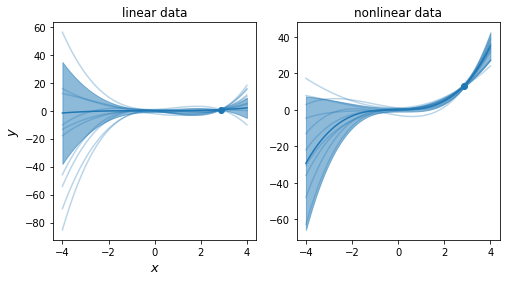

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].plot(x_plot, post_samples_linear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data[:Nobs], y_linear[:Nobs])
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].plot(x_plot, post_samples_nonlinear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data[:Nobs], y_nonlinear[:Nobs])

plt.show()

More data leads to a sharper posterior, i.e. we are becoming more certain about the function $f(\cdot)$: 

In [32]:
Nobs = 10

Kxx = Gramian(x_data[:Nobs], x_data[:Nobs], phi_cubic)
Kxs = Gramian(x_data[:Nobs], x_plot, phi_cubic)
Kss = Gramian(x_plot, x_plot, phi_cubic)

post_mean_linear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_linear[:Nobs], y_linear_cov[:Nobs, :Nobs])
post_std_linear = np.sqrt(jnp.diag(post_cov))
post_samples_linear = sample_MVN(
    rng, post_mean_linear[None, :, None].repeat(N_samps, axis=0), post_cov)


Kxx = Gramian(x_data[:Nobs], x_data[:Nobs], phi_cubic)
Kxs = Gramian(x_data[:Nobs], x_plot, phi_cubic)
Kss = Gramian(x_plot, x_plot, phi_cubic)

post_mean_nonlinear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear[:Nobs], y_nonlinear_cov[:Nobs, :Nobs])
post_std_nonlinear = np.sqrt(jnp.diag(post_cov))
post_samples_nonlinear = sample_MVN(
    rng, post_mean_nonlinear[None, :, None].repeat(N_samps, axis=0), post_cov)

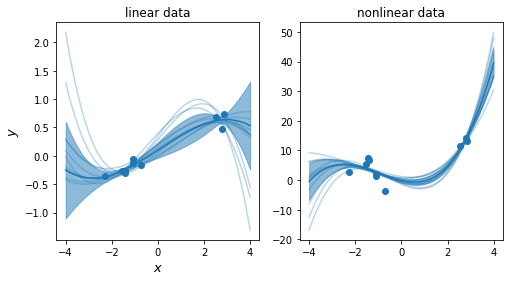

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].plot(x_plot, post_samples_linear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data[:Nobs], y_linear[:Nobs])
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].plot(x_plot, post_samples_nonlinear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data[:Nobs], y_nonlinear[:Nobs])

plt.show()

On the entire training dataset:

In [34]:
Kxx = Gramian(x_data, x_data, phi_cubic)
Kxs = Gramian(x_data, x_plot, phi_cubic)
Kss = Gramian(x_plot, x_plot, phi_cubic)

post_mean_linear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)
post_std_linear = jnp.diag(post_cov)
post_samples_linear = sample_MVN(
    rng, post_mean_linear[None, :, None].repeat(N_samps, axis=0), post_cov)


Kxx = Gramian(x_data, x_data, phi_cubic)
Kxs = Gramian(x_data, x_plot, phi_cubic)
Kss = Gramian(x_plot, x_plot, phi_cubic)

post_mean_nonlinear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)
post_std_nonlinear = jnp.diag(post_cov)
post_samples_nonlinear = sample_MVN(
    rng, post_mean_nonlinear[None, :, None].repeat(N_samps, axis=0), post_cov)

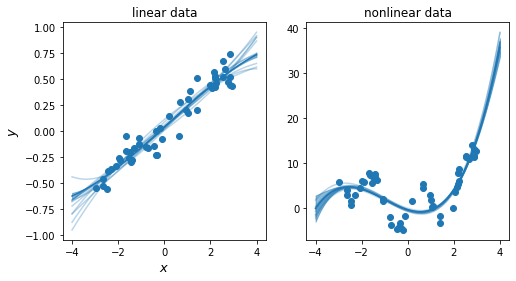

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].plot(x_plot, post_samples_linear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].plot(x_plot, post_samples_nonlinear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data, y_nonlinear)

plt.show()

In [36]:
Kxs = Gramian(x_data, x_test, phi_cubic)
Kss = Gramian(x_test, x_test, phi_cubic)
post_mean_linear, _ = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)
post_mean_nonlinear, _ = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)

R2_linear = compute_R2(post_mean_linear, y_linear_test)
R2_nonlinear = compute_R2(post_mean_nonlinear, y_nonlinear_test)

LML_linear = MVN_log_marginal(Kxx, y_linear, y_linear_cov)
LML_nonlinear = MVN_log_marginal(Kxx, y_nonlinear, y_nonlinear_cov)

bbasis_regression_dict = {
    "R2_linear": R2_linear, 
    "R2_nonlinear": R2_nonlinear, 
    "LML_linear": LML_linear, 
    "LML_nonlinear": LML_nonlinear, 
}

<a id='gp'></a>
## 4. Gaussian process regression

For a video introduction to the use of Gaussian processes in systems neuroscience, see this [link](https://www.youtube.com/watch?v=cQAPIlMeL_g).

<a id='gp_trick'></a>
### 4.1 Kernel trick

We note that the expression for evaluating function values $f(\cdot)$ in the function space perspective only involve particular combinations of the basis expansion, namely the Gramian matrix $K = \Phi^T \Phi$ and $\mathbf{\phi}^T(x_*) \, \Phi^T$ 

$$ f(x_*) = \boldsymbol{\phi}^T(x_*) \, \Phi (\Phi^T \Phi)^{-1} \mathbf{y}$$

This suggests that instead of specifying the explicit basis expansion we could directly specify some parametric form for some function $k(x,x') = \boldsymbol{\phi}^T(x) \, \boldsymbol{\phi}(x')$. This is known as the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method#Mathematics:_the_kernel_trick) in the machine learning literature, and $k(x,x')$ is called a covariance function as it specifies the covariance of the prior $p(f(\cdot))$. Note not all parametric forms of $k(x,x')$ are valid, as they must correspond to a valid covariance matrix. For example, the quadratic basis set described previously can be expresssed equivalently, up to scaling coefficients, using a quadratic kernel 

$$ k(x, x';\sigma) = \sigma^2 \, (1 + \mathbf{x} \cdot \mathbf{x}')^2$$

In particular, by specifying the kernel directly we can implicitly work with infinite basis sets. The squared exponential kernel or radial basis function 

$$ k(x, x';\sigma, l) = \sigma^2 e^{-\frac{\|x - x'\|^2 }{ 2l^2 }} $$

is an example of this, which corresponds to a basis (see section 3.1 in this [note by David Mackay](http://www.inference.org.uk/mackay/gpB.pdf))

$$\phi_u(x) \propto e^{- \frac{\|x - u\|^2 }{ l^2 }} $$

that is indexed by a continuous $u \in \mathbb{R}$. Note the covariance functions above $k(x, x';\theta)$ depend on parameters $\theta$ themselves, which are termed "hyperparameters" as they are one level above the implicit weights parameters $\mathbf{w}$ in the underlying linear basis regression model.

The covariance function and corresponding function samples look like this:

In [37]:
def SE_kernel(params, x, y):
    sigma, l = jnp.exp(params["log_sigma"]), jnp.exp(params["log_len"])
    
    x = x[:, None, :]
    y = y[None, ...]
    dist_squared = x**2 + y**2 - 2 * x * y  # (N, N, dims)
    norm_dist = (dist_squared / l**2).sum(-1)
    
    return sigma**2 * jnp.exp(-.5 * norm_dist)

In [38]:
d_x = 1
x = jnp.linspace(0., 1., 100)[:, None]
y = jnp.linspace(0., 1., 100)[:, None]

params_lin = {"log_sigma": jnp.array(0.), "log_len": jnp.zeros(d_x)}
params_non = {"log_sigma": jnp.array(0.), "log_len": jnp.zeros(d_x)}

K = SE_kernel(params_lin, x, y)

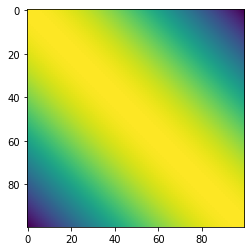

In [39]:
plt.imshow(K)
plt.show()

In [40]:
N_samps = 10

Kss = SE_kernel(params_lin, x_plot[:, None], x_plot[:, None])
Lss = jnp.linalg.cholesky(Kss + 1e-5 * jnp.eye(Kss.shape[1]))

f_samps = Lss @ rng.normal(size=(Lss.shape[-1], N_samps))

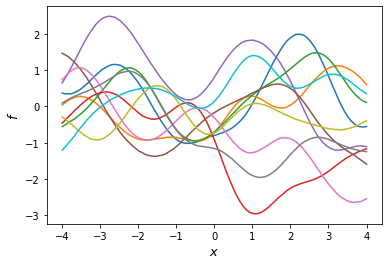

In [41]:
plt.plot(x_plot, f_samps)
plt.xlabel(r'$x$', fontsize=13)
plt.ylabel(r'$f$', fontsize=13)
plt.show()

Note the function samples here can be much more complicated than the function samples from the linear basis function models above. However, any sample must be a smooth (technically infinitely differentiable) function. This constraint is imposed by our choice of the covariance function $k(\cdot, \cdot)$, and other choices lead to different properties (for more details, see this [book](https://gaussianprocess.org/gpml/)). Hence, generative modeling provides us with a powerful way to enforce prior knowledge about some system while retaining a high level of flexibility.

We can now compute the posterior distribution under the observations using the same expressions as above in the function space. Note that we do not work in the parameter space $p(\mathbf{w}|y)$ as we have an infinite basis function set, which we side-step by directly working with the functions $f(\cdot)$.

In [42]:
Nobs = 1

Kxx = SE_kernel(params_lin, x_data[:Nobs, None], x_data[:Nobs, None])
Kxs = SE_kernel(params_lin, x_data[:Nobs, None], x_plot[:, None])
Kss = SE_kernel(params_lin, x_plot[:, None], x_plot[:, None])

post_mean_linear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_linear[:Nobs], y_linear_cov[:Nobs, :Nobs])
post_std_linear = np.sqrt(jnp.diag(post_cov))
post_samples_linear = sample_MVN(
    rng, post_mean_linear[None, :, None].repeat(N_samps, axis=0), post_cov)


Kxx = SE_kernel(params_non, x_data[:Nobs, None], x_data[:Nobs, None])
Kxs = SE_kernel(params_non, x_data[:Nobs, None], x_plot[:, None])
Kss = SE_kernel(params_non, x_plot[:, None], x_plot[:, None])

post_mean_nonlinear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear[:Nobs], y_nonlinear_cov[:Nobs, :Nobs])
post_std_nonlinear = np.sqrt(jnp.diag(post_cov))
post_samples_nonlinear = sample_MVN(
    rng, post_mean_nonlinear[None, :, None].repeat(N_samps, axis=0), post_cov)

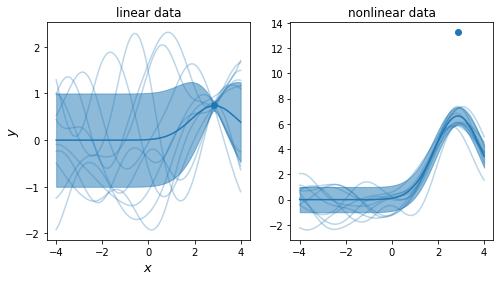

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].plot(x_plot, post_samples_linear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data[:Nobs], y_linear[:Nobs])
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].plot(x_plot, post_samples_nonlinear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data[:Nobs], y_nonlinear[:Nobs])

plt.show()

We can now compute the posterior distribution under the observations using the same expressions as above in the function space. Note that we do not work in the parameter space $p(\mathbf{w}|y)$ as we have an infinite basis function set, which we side-step by directly working with the functions $f(\cdot)$.

In [44]:
Nobs = 10

Kxx = SE_kernel(params_lin, x_data[:Nobs, None], x_data[:Nobs, None])
Kxs = SE_kernel(params_lin, x_data[:Nobs, None], x_plot[:, None])
Kss = SE_kernel(params_lin, x_plot[:, None], x_plot[:, None])

post_mean_linear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_linear[:Nobs], y_linear_cov[:Nobs, :Nobs])
post_std_linear = np.sqrt(jnp.diag(post_cov))
post_samples_linear = sample_MVN(
    rng, post_mean_linear[None, :, None].repeat(N_samps, axis=0), post_cov)


Kxx = SE_kernel(params_non, x_data[:Nobs, None], x_data[:Nobs, None])
Kxs = SE_kernel(params_non, x_data[:Nobs, None], x_plot[:, None])
Kss = SE_kernel(params_non, x_plot[:, None], x_plot[:, None])

post_mean_nonlinear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear[:Nobs], y_nonlinear_cov[:Nobs, :Nobs])
post_std_nonlinear = np.sqrt(jnp.diag(post_cov))
post_samples_nonlinear = sample_MVN(
    rng, post_mean_nonlinear[None, :, None].repeat(N_samps, axis=0), post_cov)

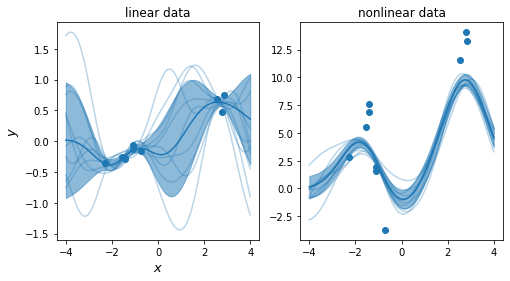

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].plot(x_plot, post_samples_linear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data[:Nobs], y_linear[:Nobs])
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].plot(x_plot, post_samples_nonlinear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data[:Nobs], y_nonlinear[:Nobs])

plt.show()

On the entire training dataset:

In [46]:
Kxx = SE_kernel(params_lin, x_data[:, None], x_data[:, None])
Kxs = SE_kernel(params_lin, x_data[:, None], x_plot[:, None])
Kss = SE_kernel(params_lin, x_plot[:, None], x_plot[:, None])

post_mean_linear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)
post_std_linear = np.sqrt(jnp.diag(post_cov))
post_samples_linear = sample_MVN(
    rng, post_mean_linear[None, :, None].repeat(N_samps, axis=0), post_cov)


Kxx = SE_kernel(params_non, x_data[:, None], x_data[:, None])
Kxs = SE_kernel(params_non, x_data[:, None], x_plot[:, None])
Kss = SE_kernel(params_non, x_plot[:, None], x_plot[:, None])

post_mean_nonlinear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)
post_std_nonlinear = np.sqrt(jnp.diag(post_cov))
post_samples_nonlinear = sample_MVN(
    rng, post_mean_nonlinear[None, :, None].repeat(N_samps, axis=0), post_cov)

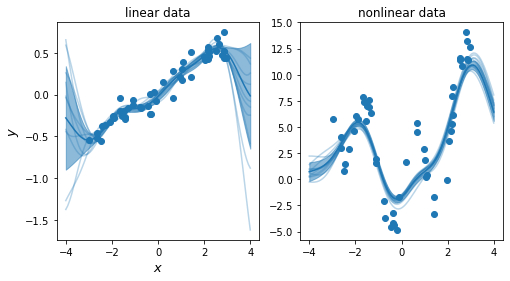

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].plot(x_plot, post_samples_linear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].plot(x_plot, post_samples_nonlinear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data, y_nonlinear)

plt.show()

Note the point estimate version of the above is commonly known as [kernel ridge regression](https://web2.qatar.cmu.edu/~gdicaro/10315-Fall19/additional/welling-notes-on-kernel-ridge.pdf).


<a id='gp_hyp'></a>
### 4.2 Choosing hyperparameters

The added flexibility however does come with a cost. Unlike the above methods based on explicit fixed basis sets, we now have to specify the hyperparameters of the kernel $\theta = (\sigma, l)$, which effectively shape the basis function set we use. One natural criterion for selecting hyperparameters in probabilisitic generative models is to maximize the marginal likelihood.

For the squared exponential covariance function, one key parameter is the lengthscale $l$, which determines how smooth or inversely how "wiggly" the posterior functions can be. As an illustration, we can visualize the marginal likelihood on the nonlinear data as a function of $l$:

In [48]:
def log_marginal_likelihood(params, x_obs, y_obs, y_cov, kernel_func):
    d_x = y_obs.shape[0]
    
    Kxx = kernel_func(params, x_obs, x_obs)
    
    Le = jnp.linalg.cholesky(Kxx + y_cov)
    Ley = jsc.linalg.solve_triangular(Le, y_obs[:, None], lower=True)
    
    lml = -.5 * (Ley.T @ Ley).sum() - .5 * d_x * jnp.log(2 * jnp.pi) - jnp.log(jnp.diag(Le)).sum()
    return lml


In [49]:
log_lens = np.linspace(-4., 2., 100)
sel_ind_plotting = [25, 50, 75]

post_means, post_stds = [], []
lml = []
for en, log_len in enumerate(log_lens):
    params = {"log_sigma": jnp.array(0.), "log_len": log_len * jnp.ones(d_x)}

    if en in sel_ind_plotting:
        Kxx = SE_kernel(params, x_data[:, None], x_data[:, None])
        Kxs = SE_kernel(params, x_data[:, None], x_plot[:, None])
        Kss = SE_kernel(params, x_plot[:, None], x_plot[:, None])

        post_mean, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)
        post_std = np.sqrt(jnp.diag(post_cov))
        post_means.append(post_mean)
        post_stds.append(post_std)

    lml.append(
        log_marginal_likelihood(params, x_data[:, None], y_nonlinear, y_nonlinear_cov, SE_kernel))

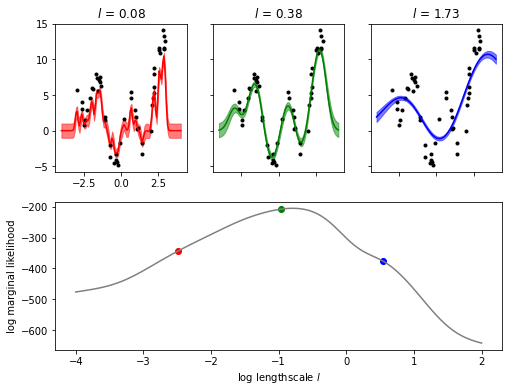

In [50]:
fig = plt.figure(figsize=(8, 6))

colors = ['r', 'g', 'b']

widths = [1, 1, 1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, wspace=0.2, hspace=0.2)


for k in range(3):
    ax = fig.add_subplot(spec[0, k])
    ax.set_title(r'$l$ = {:.2f}'.format(np.exp(log_lens[sel_ind_plotting[k]])))
    line, = ax.plot(x_plot, post_means[k], c=colors[k])
    ax.fill_between(
        x_plot, post_means[k]-post_stds[k], 
        post_means[k]+post_stds[k], 
        color=line.get_color(), alpha=0.5
    )
    ax.scatter(x_data, y_nonlinear, c='k', marker='.')
    if k > 0:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    
ax = fig.add_subplot(spec[1, :])
ax.plot(log_lens, lml, color='gray')
for k in range(3):
    ax.scatter(log_lens[sel_ind_plotting[k]], lml[sel_ind_plotting[k]], c=colors[k])
ax.set_ylabel('log marginal likelihood')
ax.set_xlabel(r'log lengthscale $l$')

    
plt.show()

In essence, tuning hyperparameters is the same as performing model selection over a continuous set of models parameterized by $\theta$, and the marginal likelihood objective we used is a score to assign which model is better. One neat aspect of the marginal likelihood, making it central to Bayesian inference, is that it automatically penalizes model complexity without the need for heuristics. In fact, many widely used model selection criteria such as the [Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) can be seen as approximations to the marginal likelihood, and this section gives intuition on how it implements a form of [Occam's razor](https://mlg.eng.cam.ac.uk/zoubin/papers/05occam/occam.pdf).


In general, the resulting optimization problem 

$$ \min_{\theta} p(\mathbf{y}|\theta) $$

is not solvable in closed form, and one has to use iterative methods such as gradient descent. Luckily in JAX, this is easily done by computing gradients with ```grad```:

In [51]:
# linear
loss_func = lambda p: -log_marginal_likelihood(p, x_data[:, None], y_linear, y_linear_cov, SE_kernel)
grad_lml = jax.jit(jax.value_and_grad(loss_func))  # JIT to make it fast
_, _, = grad_lml(params_lin)  # compile

opt_init, opt_update, get_params = optimizers.adam(step_size=5e-3)
opt_state = opt_init(params_lin)

print('optimising the hyperparameters ...')

losses_lin = []
for i in range(1000):
    params_lin = get_params(opt_state)
    
    loss, gradients = grad_lml(params_lin)
    if (i % 100) == 0:
        print('iter %2d: nlml=%2.2f' % (i, loss))

    opt_state = opt_update(i, gradients, opt_state)
    losses_lin.append(loss)
    
    
# nonlinear
loss_func = lambda p: -log_marginal_likelihood(p, x_data[:, None], y_nonlinear, y_nonlinear_cov, SE_kernel)
grad_lml = jax.jit(jax.value_and_grad(loss_func))  # JIT to make it fast
_, _, = grad_lml(params_non)  # compile

opt_init, opt_update, get_params = optimizers.adam(step_size=5e-3)
opt_state = opt_init(params_non)

print('optimising the hyperparameters ...')

losses_non = []
for i in range(1000):
    params_non = get_params(opt_state)
    
    loss, gradients = grad_lml(params_non)
    if (i % 100) == 0:
        print('iter %2d: nlml=%2.2f' % (i, loss))

    opt_state = opt_update(i, gradients, opt_state)
    losses_non.append(loss)

optimising the hyperparameters ...
iter  0: nlml=-27.31
iter 100: nlml=-33.79
iter 200: nlml=-35.31
iter 300: nlml=-35.37
iter 400: nlml=-35.38
iter 500: nlml=-35.39
iter 600: nlml=-35.39
iter 700: nlml=-35.39
iter 800: nlml=-35.39
iter 900: nlml=-35.39
optimising the hyperparameters ...
iter  0: nlml=301.83
iter 100: nlml=149.92
iter 200: nlml=117.15
iter 300: nlml=106.83
iter 400: nlml=102.26
iter 500: nlml=99.87
iter 600: nlml=98.47
iter 700: nlml=97.57
iter 800: nlml=96.94
iter 900: nlml=96.47


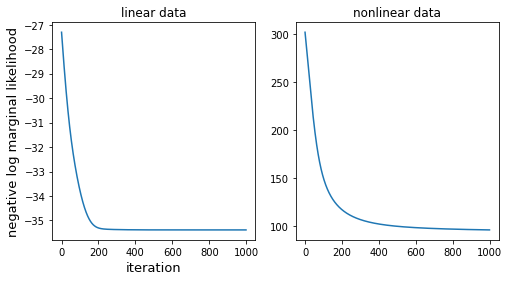

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(losses_lin)
axes[0].set_xlabel('iteration', fontsize=13)
axes[0].set_ylabel('negative log marginal likelihood', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(losses_non)

plt.show()

In [53]:
Kxx = SE_kernel(params_lin, x_data[:, None], x_data[:, None])
Kxs = SE_kernel(params_lin, x_data[:, None], x_plot[:, None])
Kss = SE_kernel(params_lin, x_plot[:, None], x_plot[:, None])

post_mean_linear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)
post_std_linear = np.sqrt(jnp.diag(post_cov))
post_samples_linear = sample_MVN(
    rng, post_mean_linear[None, :, None].repeat(N_samps, axis=0), post_cov)


Kxx = SE_kernel(params_non, x_data[:, None], x_data[:, None])
Kxs = SE_kernel(params_non, x_data[:, None], x_plot[:, None])
Kss = SE_kernel(params_non, x_plot[:, None], x_plot[:, None])

post_mean_nonlinear, post_cov = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)
post_std_nonlinear = np.sqrt(jnp.diag(post_cov))
post_samples_nonlinear = sample_MVN(
    rng, post_mean_nonlinear[None, :, None].repeat(N_samps, axis=0), post_cov)

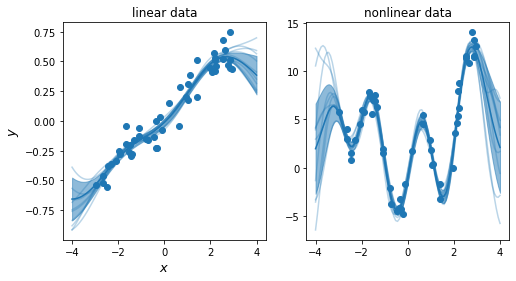

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
line, = axes[0].plot(x_plot, post_mean_linear)
axes[0].plot(x_plot, post_samples_linear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[0].fill_between(
    x_plot, post_mean_linear-post_std_linear, post_mean_linear+post_std_linear, 
    color=line.get_color(), alpha=0.5
)
axes[0].scatter(x_data, y_linear)
axes[0].set_xlabel(r'$x$', fontsize=13)
axes[0].set_ylabel(r'$y$', fontsize=13)

axes[1].set_title('nonlinear data')
line, = axes[1].plot(x_plot, post_mean_nonlinear)
axes[1].plot(x_plot, post_samples_nonlinear[..., 0].T, color=line.get_color(), alpha=0.3)
axes[1].fill_between(
    x_plot, post_mean_nonlinear-post_std_nonlinear, 
    post_mean_nonlinear+post_std_nonlinear, 
    color=line.get_color(), alpha=0.5
)
axes[1].scatter(x_data, y_nonlinear)

plt.show()

The final marginal likelihood and test performance:

In [55]:
Kxx = SE_kernel(params_lin, x_data[:, None], x_data[:, None])
Kxs = SE_kernel(params_lin, x_data[:, None], x_test[:, None])
Kss = SE_kernel(params_lin, x_test[:, None], x_test[:, None])
post_mean_linear, _ = MVN_posterior(Kxs, Kxx, Kss, y_linear, y_linear_cov)

Kxx = SE_kernel(params_non, x_data[:, None], x_data[:, None])
Kxs = SE_kernel(params_non, x_data[:, None], x_test[:, None])
Kss = SE_kernel(params_non, x_test[:, None], x_test[:, None])
post_mean_nonlinear, _ = MVN_posterior(Kxs, Kxx, Kss, y_nonlinear, y_nonlinear_cov)

R2_linear = compute_R2(post_mean_linear, y_linear_test)
R2_nonlinear = compute_R2(post_mean_nonlinear, y_nonlinear_test)

LML_linear = log_marginal_likelihood(params_lin, x_data[:, None], y_linear, y_linear_cov, SE_kernel)
LML_nonlinear = log_marginal_likelihood(params_non, x_data[:, None], y_nonlinear, y_nonlinear_cov, SE_kernel)

gp_regression_dict = {
    "R2_linear": R2_linear, 
    "R2_nonlinear": R2_nonlinear, 
    "LML_linear": LML_linear, 
    "LML_nonlinear": LML_nonlinear, 
}

<a id='disc'></a>
## 5. Discussion

<a id='disc_comp'></a>
### 5.1 Comparing model performances

We see that on the linear dataset, all models performed comparably. Generally, one can expect slight decrease in test performance of more flexible models due to potential overfitting when averaging over many independent realizations of the linear datasets. On the nonlinear dataset however, significant increase in performance can be seen for the more flexible models. The log marginal likelihood and test $R^2$ give consistent pictures.

In [56]:
names = ['linear regression', 'Bayesian linear', 'cubic basis', 'Bayesian cubic', 'Gaussian process']
lml_names = [names[1], names[3], names[4]]

# coefficient of determinations
R2_linears = [
    linear_regression_dict["R2_linear"], 
    blinear_regression_dict["R2_linear"], 
    basis_regression_dict["R2_linear"], 
    bbasis_regression_dict["R2_linear"], 
    gp_regression_dict["R2_linear"], 
]

R2_nonlinears = [
    linear_regression_dict["R2_nonlinear"], 
    blinear_regression_dict["R2_nonlinear"], 
    basis_regression_dict["R2_nonlinear"], 
    bbasis_regression_dict["R2_nonlinear"], 
    gp_regression_dict["R2_nonlinear"], 
]

# log marginal likelihoods
LML_linears = [
    blinear_regression_dict["LML_linear"], 
    bbasis_regression_dict["LML_linear"], 
    gp_regression_dict["LML_linear"], 
]

LML_nonlinears = [
    blinear_regression_dict["LML_nonlinear"], 
    bbasis_regression_dict["LML_nonlinear"], 
    gp_regression_dict["LML_nonlinear"], 
]

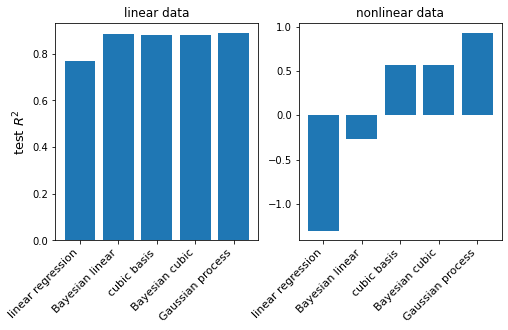

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].bar(np.arange(len(names)), R2_linears)
axes[0].set_xticks(np.arange(len(names)))
axes[0].set_xticklabels(names, rotation=45, ha='right', fontsize=11)
axes[0].set_ylabel(r'test $R^2$', fontsize=13)

axes[1].set_title('nonlinear data')
axes[1].bar(np.arange(len(names)), R2_nonlinears)
axes[1].set_xticks(np.arange(len(names)))
axes[1].set_xticklabels(names, rotation=45, ha='right', fontsize=11)


plt.show()

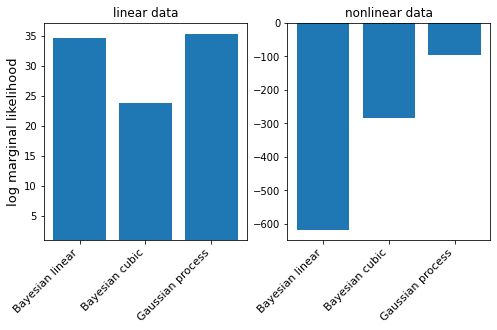

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('linear data')
axes[0].bar(np.arange(len(lml_names)), LML_linears)
axes[0].set_xticks(np.arange(len(lml_names)))
axes[0].set_xticklabels(lml_names, rotation=45, ha='right', fontsize=11)
axes[0].set_ylabel('log marginal likelihood', fontsize=13)
axes[0].set_ylim(0.9)

axes[1].set_title('nonlinear data')
axes[1].bar(np.arange(len(lml_names)), LML_nonlinears)
axes[1].set_xticks(np.arange(len(lml_names)))
axes[1].set_xticklabels(lml_names, rotation=45, ha='right', fontsize=11)


plt.show()

<a id='disc_note'></a>
### 5.2 A note on non-Gaussian observations and beyond

The models above have a simple structure, more specifically Gaussian observation noise and priors while being linear in $\mathbf{w}$. This results in closed form marginal likelihoods and posteriors. Real world data, including neural data, is generally not well described by Gaussian observation noise. Other likelihoods such as the log normal distribution (for positive values), Poisson distribution (count data as in electrophysiological recordings) and many more generally do not have closed form solutions, and one needs to rely on approximate inference techniques. Furthermore, the moment we step away from the simple linear basis function structure, inference quickly becomes intractable even with Gaussian likelihoods. Many methods have been proposed for specific subsets of generative models, some which we will see in the other notebooks on latent variable models and discrete latent spaces, and this is still an active area of research in machine learning.